In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import sys, importlib
PROJECT_ROOT = "/content/drive/MyDrive/SA_CropType_SourceCoop"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

import common
importlib.reload(common)
from common import *

ensure_dirs()

print("✅ BASE_DIR:", BASE_DIR)
print("✅ FIELD_INFO_TRAIN:", FIELD_INFO_TRAIN, "exists:", FIELD_INFO_TRAIN.exists())
print("✅ LABELS_DIR:", LABELS_DIR, "exists:", LABELS_DIR.exists())
print("✅ S2_DIR:", S2_DIR, "exists:", S2_DIR.exists())
print("✅ S1_DIR:", S1_DIR, "exists:", S1_DIR.exists())
print("✅ OUT_DIR:", OUT_DIR, "exists:", OUT_DIR.exists())
print("✅ TFC_FILE:", TFC_FILE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ BASE_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop
✅ FIELD_INFO_TRAIN: /content/drive/MyDrive/SA_CropType_SourceCoop/field_info_train.csv exists: True
✅ LABELS_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop/train/labels exists: True
✅ S2_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop/train/imagery/s2 exists: True
✅ S1_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop/train/imagery/s1 exists: True
✅ OUT_DIR: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs exists: True
✅ TFC_FILE: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/meta/tile_field_crop_table.csv


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt



In [ ]:
df = pd.read_csv(FIELD_INFO_TRAIN)
print(df.head())
print(df.columns.tolist())

   Field ID    Crop
0     84337  Fallow
1     91979   Weeds
2    119964   Weeds
3     43134   Weeds
4     95735  Fallow
['Field ID', 'Crop']


In [ ]:
df = df.rename(columns={
    "Field ID": "field_id",
    "Crop": "crop",
    "crop": "crop"
})

assert "field_id" in df.columns
assert "crop" in df.columns

print("Kolonlar:", df.columns.tolist())

Kolonlar: ['field_id', 'crop']


In [ ]:
print("=" * 80)
print("VERİ YAPISI DETAYLARI")
print("=" * 80)

print("\n📊 Sütun Bilgileri:")
print(df.info())

print("\n📈 İstatistikler:")
print(df.describe(include="all"))

print("\n⚠️ Eksik Değerler:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "Eksik değer yok ✓")

print(f"\n🔢 Benzersiz field_id: {df['field_id'].nunique():,}")
print(f"🔢 Toplam satır: {len(df):,}")

VERİ YAPISI DETAYLARI

📊 Sütun Bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87113 entries, 0 to 87112
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   field_id  87113 non-null  int64 
 1   crop      87113 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
None

📈 İstatistikler:
             field_id         crop
count    87113.000000        87113
unique            NaN            9
top               NaN  Wine grapes
freq              NaN        24225
mean     61455.602780          NaN
std      35422.522636          NaN
min          1.000000          NaN
25%      30779.000000          NaN
50%      61460.000000          NaN
75%      92130.000000          NaN
max     122736.000000          NaN

⚠️ Eksik Değerler:
Eksik değer yok ✓

🔢 Benzersiz field_id: 87,113
🔢 Toplam satır: 87,113


In [ ]:
target_crops = [
    "Wine grapes",
    "Wheat",
    "Planted pastures (perennial)",
    "Lucerne/Medics"
]

crop_counts = df["crop"].value_counts()

print("🔝 En yaygın ürünler:")
print(crop_counts.head(10))

df_target = df[df["crop"].isin(target_crops)]

print("\n🎯 Hedef ürünler:")
print(df_target["crop"].value_counts())

print(f"\nToplam hedef tarla sayısı: {len(df_target):,}")
print(f"Toplam içindeki oran: %{len(df_target)/len(df)*100:.2f}")

🔝 En yaygın ürünler:
crop
Wine grapes                     24225
Planted pastures (perennial)    13917
Wheat                           10712
Lucerne/Medics                   8340
Small grain grazing              8249
Weeds                            8137
Fallow                           7915
Rooibos                          4124
Canola                           1494
Name: count, dtype: int64

🎯 Hedef ürünler:
crop
Wine grapes                     24225
Planted pastures (perennial)    13917
Wheat                           10712
Lucerne/Medics                   8340
Name: count, dtype: int64

Toplam hedef tarla sayısı: 57,194
Toplam içindeki oran: %65.65


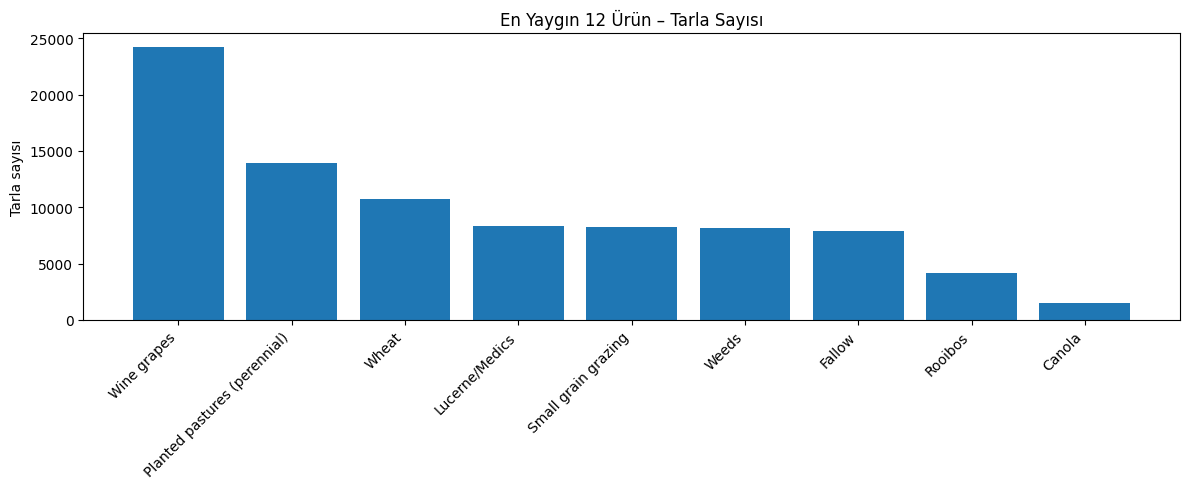

In [ ]:
import matplotlib.pyplot as plt

TOP_N = 12
crop_counts = df["crop"].value_counts().head(TOP_N)

plt.figure(figsize=(12, 5))
plt.bar(crop_counts.index, crop_counts.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Tarla sayısı")
plt.title(f"En Yaygın {TOP_N} Ürün – Tarla Sayısı")
plt.tight_layout()

save_fig("notebook1_top12_crop_distribution")
plt.show()


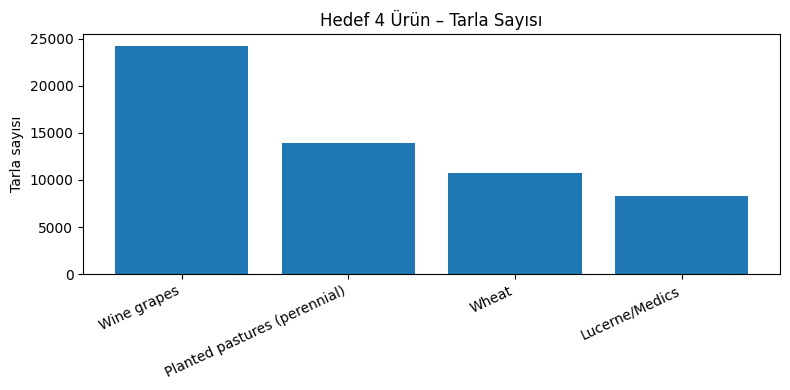

In [ ]:
target_crops = [
    "Wine grapes",
    "Wheat",
    "Planted pastures (perennial)",
    "Lucerne/Medics"
]

target_counts = df[df["crop"].isin(target_crops)]["crop"].value_counts()

plt.figure(figsize=(8, 4))
plt.bar(target_counts.index, target_counts.values)
plt.xticks(rotation=25, ha="right")
plt.ylabel("Tarla sayısı")
plt.title("Hedef 4 Ürün – Tarla Sayısı")
plt.tight_layout()

save_fig("notebook1_target4_crop_distribution")
plt.show()


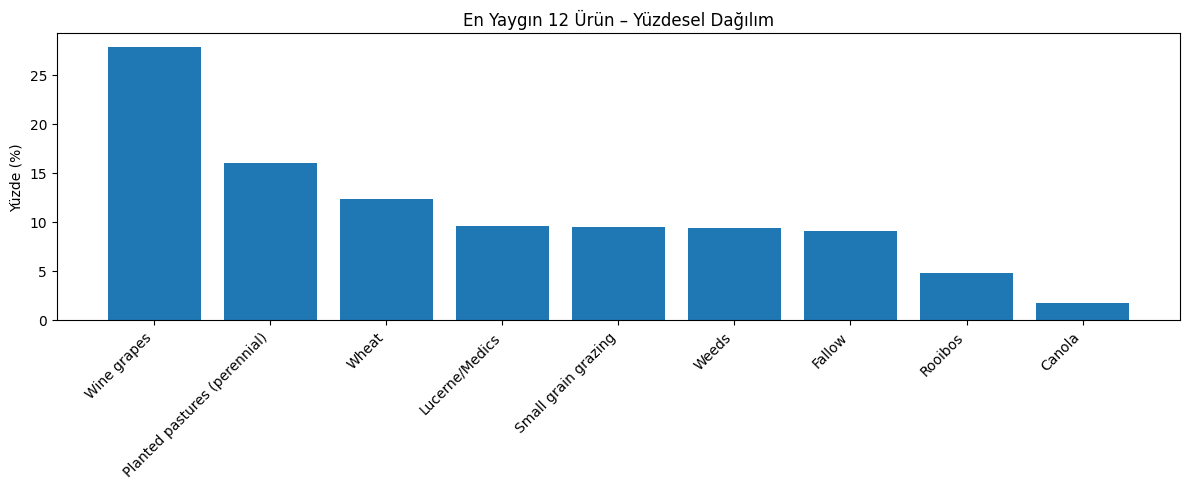

In [ ]:
pct = (df["crop"].value_counts(normalize=True) * 100).head(12)

plt.figure(figsize=(12, 5))
plt.bar(pct.index, pct.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Yüzde (%)")
plt.title("En Yaygın 12 Ürün – Yüzdesel Dağılım")
plt.tight_layout()

save_fig("notebook1_top12_crop_percentage")
plt.show()
